In [1]:
# %matplotlib_svg
import pandas as pd
import numpy as np
import pylab as pl
pd.set_option("display.show_dimensions", False)
pd.set_option("display.float_format", "{:4.2g}".format)
df_soil = pd.read_csv("data/Soils-simple.csv", index_col=[0, 1], usecols=range(6))

## 數值運算函數

`Series` 和 `DataFrame` 物件都支援 numpy 的陣列介面，因此可以直接使用 numpy 提供的 `ufunc` 函數對它們進行運算。此外它們還提供各種運算方法，例如 `max()`, `min()`, `mean()`, `std()` 等。這些函數都有以下三個常用參數：
- `axis`：指定運算對應的軸。
- `level`：指定運算對應的索引等級。
- `skipna`：運算是否自動跳過 `NaN`。

In [2]:
df_soil

pH  Dens   Ca  Conduc
Depth Contour                           
0-10  Depression  5.4  0.98   11     1.5
      Slope       5.5   1.1   12       2
      Top         5.3     1   13     1.4
10-30 Depression  4.9   1.4  7.5     5.5
      Slope       5.3   1.3  9.5     4.9
      Top         4.8   1.3   10     3.6

下面分別計算每列的平均值、每行的平均值 以及 行索引的第 1 等級 Contour 中每個等高線對應的平均值：

In [3]:
# %C df_soil.mean(); df_soil.mean(axis=1); df_soil.mean(level=1)
print( df_soil.mean() )
print("-"*20)
print( df_soil.mean(axis=1) )
print("-"*20)
print( df_soil.mean(level=1) ) 

pH        5.2
Dens      1.2
Ca         11
Conduc    3.1
dtype: float64
--------------------
Depth  Contour   
0-10   Depression    4.6
       Slope         5.2
       Top           5.3
10-30  Depression    4.8
       Slope         5.3
       Top             5
dtype: float64
--------------------
             pH  Dens   Ca  Conduc
Contour                           
Depression  5.1   1.2  9.1     3.5
Slope       5.4   1.2   11     3.5
Top         5.1   1.2   12     2.5


除了支援加減乘除等運算子之外， Pandas 還提供了 `add()`, `sub()`, `mul()`, `div()`, `mod()` 等與二元運算子對應的函數。這些函數可以透過 `axis`, `level`, `fill_value` 等參數控制其運算行為。在下面的實例中，對不同的等高線的 Ca 的值乘上不同的係數，`fill_value` 參數為 `1` 表示對於不存在的值或 `NaN` 使用預設值 `1` 。因此結果中。所有 Depression 對應的值為原來的 0.9 倍， Slope 對應的值為原來的 1.2 倍，而 Top 對應的值保持不變。

In [4]:
s = pd.Series(dict(Depression=0.9, Slope=1.2))
df_soil.Ca.mul(s, level=1, fill_value=1)

Depth  Contour   
0-10   Depression    9.6
       Slope          15
       Top            13
10-30  Depression    6.8
       Slope          11
       Top            10
dtype: float64

Pandas 還提供了 `rolling_*()` 函數來對序列中相鄰的 N 個元素進行移動視窗運算。例如可以使用 `rolling_median()` 實現中值濾波，使用 `rolling_mean()` 計算移動平均。圖顯示了使用這兩個函數對帶脈衝雜訊的正弦波進行處理的結果。它們的第二個參數為視窗包含的元素個數，而 `create` 參數為 `True` 表示移動視窗以目前元素為中心。

(2022-01-19) 新版 Pandas 己經不支援 `pd.rolling_mean(df, ma)` 及 `pd.rolling_median(df, ma)`，請改用 `df.rolling(ma).mean()` 及 `df.rolling(ma).median()`

In [5]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號無法正常顯示時，需加這行 code

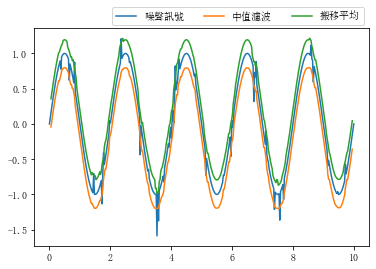

In [6]:
#%fig=中值濾波和搬移平均
t = np.linspace(0, 10, 400)
x = np.sin(0.5*2*np.pi*t)
x[np.random.randint(0, len(t), 40)] += np.random.normal(0, 0.3, 40)
s = pd.Series(x, index=t)
# s_mean = pd.rolling_mean(s, 5, center=True)
s_mean = s.rolling(5, center=True).mean()
# s_median = pd.rolling_median(s, 5, center=True)
s_median = s.rolling(5, center=True).median()
#%hide
ax = s.plot(label=u"噪聲訊號")
(s_median - 0.2).plot(ax=ax, label=u"中值濾波")
(s_mean + 0.2).plot(ax=ax, label=u"搬移平均")
ax.legend(loc="best", ncol=3, bbox_to_anchor=(0., 1.02, 1., .102));

> **QUESTION**

> 請讀者思考如何使用NumPy提供的ufunc函數計算`ref:fig-next`中的三條曲線。

`expanding_*()` 函數對序列進行擴充視窗運算，例如 `expanding_max()` 傳回到每個元素為止的歷史最大值。下圖顯示了 `expanding_max()`, `expanding_mean()`, `expanding_min()` 的運算結果。

PS: 新版 Pandas 不支援 `pd.expanding_*()`，請改用 `df['a'].expanding().*()` 

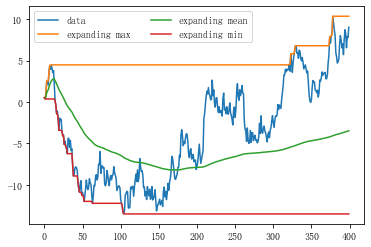

In [7]:
#%fig=用`expanding_*`計算歷史最大值、平均值、最小值
np.random.seed(42)
x = np.cumsum(np.random.randn(400))
# x_max = pd.expanding_max(x)
# x_min = pd.expanding_min(x)
# x_mean = pd.expanding_mean(x)
x = pd.DataFrame(x, columns=['a'])
x_max = x['a'].expanding().max()
x_min = x['a'].expanding().min()
x_mean = x['a'].expanding().mean()

#%hide
df = pd.DataFrame(np.c_[x, x_max, x_mean, x_min], 
                  columns=["data", "expanding max", "expanding mean", "expanding min"])
ax = df.plot()
ax.legend(ncol=2, loc="upper left");